In [1]:
# dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
%matplotlib inline
# import dependencies
from getpass import getpass
import sqlalchemy
from sqlalchemy import Column, Integer, String, ForeignKey, create_engine, text
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# SQL Alchemy connection from RDS
secret = getpass('Enter the secret value: ')

args ={
    'host':"ogdataset.c11hekhsylui.us-west-1.rds.amazonaws.com",
    'port':'5432',
    'database':"og_dataset",
    'user':"attritionProject",
    'password':secret
}
engine = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}".format(**args))
connection = engine.connect()

Enter the secret value: ········


/Users/stephen/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# read in table from database
attrition_df = pd.read_sql('SELECT * FROM new_encoded_data', connection)
attrition_df

,Age,Attrition,Business Travel,Department,Distance from Home,Education Level,Education Field,Environment Satisfaction,Gender,Job Involvement,...,Performance Rating,Relationship Satisfaction,Stock Option Level,Total Working Years,Training Times Last Year,Work Life Balance,Years at Company,Years In Current Role,Years Since Last Promotion,Years With Current Manager
0,41,1,2,2,1,2,1,2,0,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,1,8,1,1,3,1,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1,2,2,4,4,1,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1,3,4,1,4,0,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,1,2,1,3,1,1,3,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,1,1,23,2,3,3,1,4,...,3,3,1,17,3,3,5,2,0,3
1466,39,0,2,1,6,1,3,4,1,2,...,3,1,1,9,5,3,7,7,1,7
1467,27,0,2,1,4,3,1,2,1,4,...,4,2,1,6,0,3,6,2,0,3
1468,49,0,1,2,2,3,3,4,1,2,...,3,4,0,17,3,2,9,6,0,8


In [4]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [5]:
# Split the preprocessed data into a training and testing dataset
# Split our preprocessed data into our features and target arrays
X = attrition_df.drop("Attrition",1)
y = attrition_df["Attrition"].values
X_traino, X_testo, y_traino, y_testo = train_test_split(X, y, random_state=78, test_size= 0.20, train_size= 0.80, stratify =y)

/Users/stephen/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler# define oversampling strategy
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_traino, y_traino)
# summarize class distribution
print(Counter(y_over))

Counter({0: 986, 1: 986})


In [7]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scalero = scaler.fit(X_over)

# Scale the data
X_train_scaledo = X_scalero.transform(X_over)
X_test_scaledo = X_scalero.transform(X_testo)

In [31]:
Foresto = RandomForestClassifier(random_state=77, n_estimators=5000)
Foresto.fit(X_over, y_over)
print(f'Training Score: {Foresto.score(X_train_scaledo, y_over)}')
print(f'Testing Score: {Foresto.score(X_test_scaledo, y_testo)}')

Training Score: 0.5907707910750507
Testing Score: 0.4523809523809524


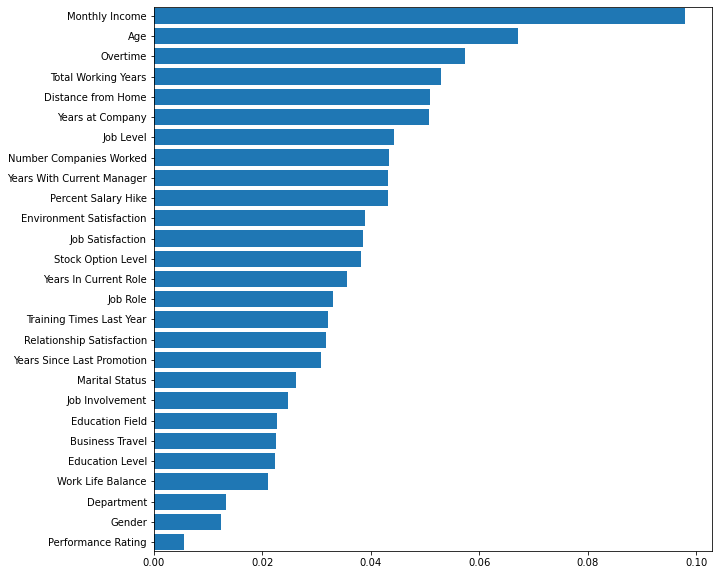

In [32]:
feature_importances = Foresto.feature_importances_
features = sorted(zip(X.columns, Foresto.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [33]:
y_trueo = y_testo
y_pred_testo = Foresto.predict(X_testo)
#y_pred_testo

In [34]:
confusion_matrix(y_trueo, y_pred_testo)

array([[241,   6],
       [ 38,   9]])

In [35]:
accuracy_score(y_trueo, y_pred_testo)

0.8503401360544217

In [36]:
print(classification_report(y_trueo, y_pred_testo))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       247
           1       0.60      0.19      0.29        47

    accuracy                           0.85       294
   macro avg       0.73      0.58      0.60       294
weighted avg       0.82      0.85      0.82       294



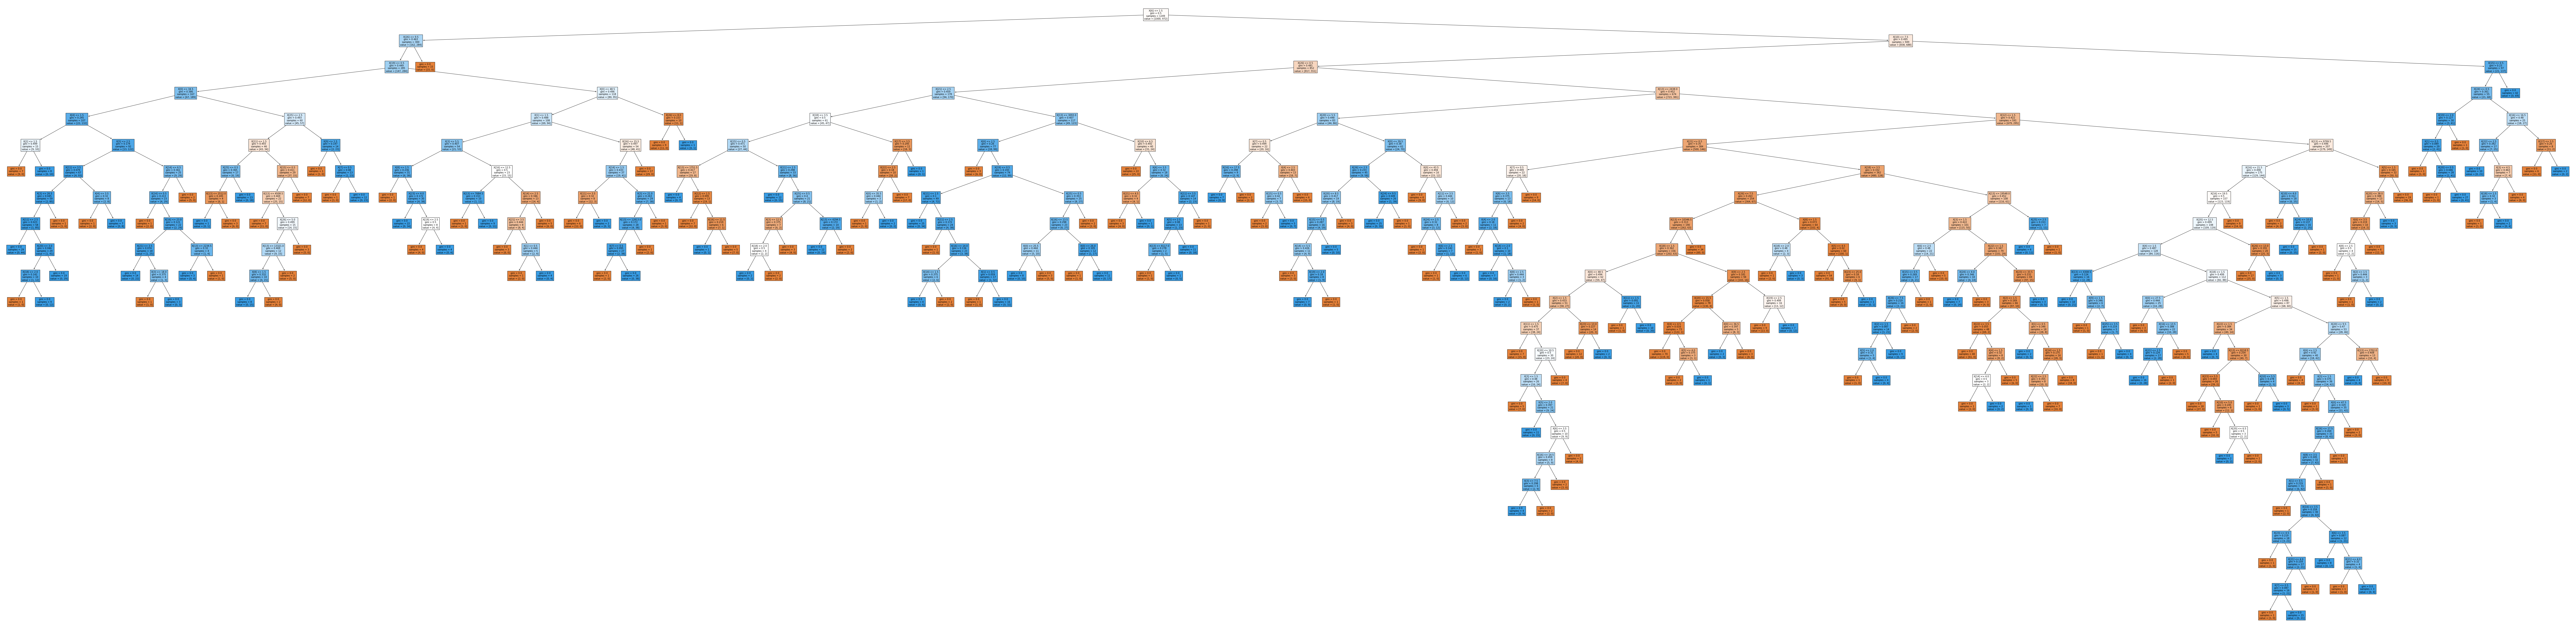

In [37]:
from sklearn import tree
plt.figure(figsize=(200,50))  # set plot size (denoted in inches)
tree.plot_tree(Foresto.estimators_[10],filled = True, fontsize=10)
plt.show()